In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

hfont = {'fontname':'Arial'}
import plotly.express as px
import plotly.graph_objects as go

import os
import sys
sys.path.append(os.path.abspath('..'))

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

np.random.seed(4)
from scipy.stats import norm
from hola.algorithm import HOLA
from scipy.stats.qmc import Sobol
from hola.tune import tune
import random
pd.set_option('display.max_columns', None)
import timeit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv(r'./data/df_simulated_large_signal_modulated.csv')  
df = df[df['VGS'] <= -1.2] # Removes all VGS values greater than -1.2 V
df.to_csv(r'./file_check/file_filtered.csv') 


df['ACLR'] = abs(df['ACLR'])
df['Tj'] = -df['Tj']

data_min = df.groupby(['VDS','Wg', 'nfing', 'gdg_val', 'gsg_val']).agg(['min'])
data_min.to_csv(r'./file_check/file_grouped.csv')
df_min = pd.read_csv(r'./file_check/file_grouped.csv') 
df_min['ACLR'] = pd.to_numeric(df_min['ACLR'], errors='coerce')
df_min = df_min[df_min['ACLR'] >= 30]

arr = df_min.to_numpy()
arr_min = arr[2:, :] 
df_min.to_csv(r'./file_check/file_grouped_post_process.csv')


arr_vds = (arr_min[:, 0]).astype(float)
arr_wg = (arr_min[:, 1]).astype(float)
arr_nfing = (arr_min[:, 2]).astype(float)
arr_gdg = (arr_min[:, 3]).astype(float)
arr_gsg = (arr_min[:, 4]).astype(float)
arr_area = arr_nfing*arr_wg

arr_Gain_mod = (arr_min[:, 12]).astype(float) 
arr_Psat_mod = (arr_min[:, 14]).astype(float) 
arr_PBO_mod = (arr_min[:, 15]).astype(float) 
arr_Pout_mod = (arr_min[:, 17]).astype(float) # Want to maximize
arr_PAE_mod = (arr_min[:, 8]).astype(float) # Want to maximize
arr_ACPR = (arr_min[:, 9]).astype(float) # Want to minimize
arr_Tj_mod = abs((arr_min[:, 10]).astype(float)) # Want to minimize

vds_count = len(np.unique(arr_vds))
wg_count = len(np.unique(arr_wg))
nfing_count = len(np.unique(arr_nfing))
gdg_count = len(np.unique(arr_gdg))
gsg_count = len(np.unique(arr_gsg))

total_count = vds_count*wg_count*nfing_count*(gdg_count*gsg_count)
print(total_count)

672


In [3]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, cost in enumerate(costs):
        if is_efficient[i]:
            is_efficient[i] = np.all(np.any(costs>=cost, axis=1))
    return is_efficient

data = np.column_stack((-arr_Pout_mod, -arr_PAE_mod, arr_Tj_mod))

pareto_efficient = is_pareto_efficient(data)

pp = data[pareto_efficient] # Non-dominated points

dp = data[~pareto_efficient] # Dominated points

# To get back the original values, multiply the first three columns by -1 
pp[:, :2] *= -1 
dp[:, :2] *= -1 
print(pp.shape)
print(dp.shape)

(39, 3)
(489, 3)


<ipython-input-4-7af9b6efdfc9>:69: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(x_ranges[i])
<ipython-input-4-7af9b6efdfc9>:70: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(y_ranges[i])


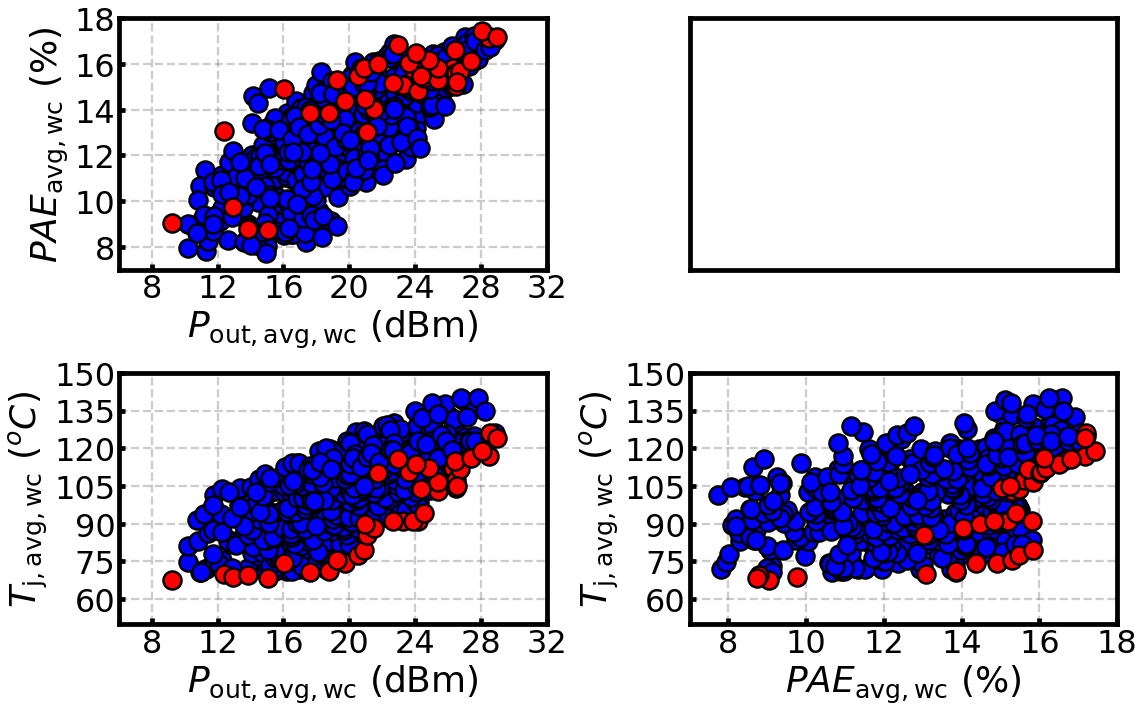

In [4]:
data1_x = dp[:,0]
data1_y = dp[:,1]
data2_x = dp[:,0]
data2_y = dp[:,1]
data3_x = dp[:,0]
data3_y = dp[:,2]
data4_x = dp[:,1]
data4_y = dp[:,2]

data1_x2 = pp[:,0]
data1_y2 = pp[:,1]
data2_x2 = pp[:,0]
data2_y2 = pp[:,1]
data3_x2 = pp[:,0]
data3_y2 = pp[:,2]
data4_x2 = pp[:,1]
data4_y2 = pp[:,2]

x_labels = [
    r'$P_{\mathrm{out,avg,wc}}$ (dBm)',
    r'',
    r'$P_{\mathrm{out,avg,wc}}$ (dBm)',
    r'$PAE_{\mathrm{avg,wc}}$ (%)'
]

y_labels = [
    r'$PAE_{\mathrm{avg,wc}}$ (%)',
    r'',
    r'$T_{\mathrm{j,avg,wc}}$ ($^{o}C$)',
    r'$T_{\mathrm{j,avg,wc}}$ ($^{o}C$)'
]

x_ticks = [
    np.arange(8, 33, 4),
    np.arange(0, 0, 1),
    np.arange(8, 33, 4),
    np.arange(6, 19, 2)
]

y_ticks = [
    np.arange(6, 19, 2),
    np.arange(0, 0, 1),
    np.arange(60, 151, 15),
    np.arange(60, 151, 15)
]

x_ranges = [
    (6, 32),
    (0, 0),
    (6, 32),
    (7, 18)
]

y_ranges = [
    (7, 18),
    (0, 0),
    (50, 150),
    (50, 150)
]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # Adjusted for 2x2 subplots

for i, ax in enumerate(axs.flat):
    ax.scatter(eval(f'data{i+1}_x'), eval(f'data{i+1}_y'), color='blue', label='Dominated', edgecolors='black', linewidths=2.5, s=325, zorder=2)
    ax.scatter(eval(f'data{i+1}_x2'), eval(f'data{i+1}_y2'), color='red', label='Pareto', edgecolors='black', linewidths=2.5, s=325, zorder=3)

    ax.set_xticks(x_ticks[i])
    ax.set_yticks(y_ticks[i])
    ax.set_xlim(x_ranges[i])
    ax.set_ylim(y_ranges[i])
    ax.set_xlabel(x_labels[i], fontsize=36, color='black')
    ax.set_ylabel(y_labels[i], fontsize=36, color='black')

    line_width = 4.75
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)

    ax.tick_params(axis='both', which='major', direction='in', length=6, width=4.75, colors='black', labelsize=32)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, colors='black')

    ax.grid(True, which='both', color='grey', linestyle='--', linewidth=2.25, zorder=0, alpha=0.4)

plt.show()
# fig.savefig("Fig_2_v2.pdf", format='pdf', bbox_inches='tight')


In [5]:
def plot_pareto_frontier_3d(data, pareto_front):
    fig = plt.figure(figsize=(7, 7), dpi=1000)  # Increased figure size

    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', s=250,edgecolors='black', linewidths=1.5, zorder=2, alpha=0.1)
    ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], c='red', s=250, edgecolors='black', linewidths=1.5, zorder=3, alpha=1)

    ax.set_xlabel(r'$P_{\mathrm{out,avg,wc}}$ (dBm)', fontsize=24, color='black', labelpad=20)
    ax.set_ylabel(r'$PAE_{\mathrm{avg,wc}}$ (%)', fontsize=24, color='black', labelpad=20)
    ax.set_zlabel(r'$T_{\mathrm{j,avg,wc}}$ ($^{o}C$)', fontsize=24, color='black', labelpad=20)

    ax.set_xlim([8, 32])
    ax.set_ylim([6, 18])
    ax.set_zlim([60, 150])  
    
    x_ticks = np.arange(8, 33, 4)
    y_ticks = np.arange(6, 19, 3)
    z_ticks = np.arange(60, 161, 20)  

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_zticks(z_ticks)

    for t in ax.get_xticklabels():
        t.set_rotation(45)
    for t in ax.get_yticklabels():
        t.set_rotation(45)

    ax.tick_params(axis='both', which='major', direction='in', length=0, width=0, colors='black', labelsize=18, zorder=0)
    ax.tick_params(axis='both', which='minor', direction='in', length=0, width=0, colors='black', zorder=0)

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    for a in (ax.w_xaxis, ax.w_yaxis, ax.w_zaxis):
        for t in a.get_ticklines() + a.get_ticklabels():
            t.set_visible(True)
        a.line.set_visible(True)
        a.pane.set_visible(True)

    ax.grid(True, linestyle='--', color='gray', linewidth=4.25, alpha=0.1)
    ax.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax.zaxis._axinfo["grid"]['linestyle'] = "--"

    plt.tight_layout()
    plt.show()
#     fig.savefig("PAE_vs_Pout_vs_Tj_3d_v2.pdf", format='pdf', bbox_inches='tight')

plot_pareto_frontier_3d(dp, pp)


In [6]:
data_attr = np.column_stack((arr_vds , arr_nfing, arr_wg, arr_gdg, arr_gsg))
data_attr_pareto = data_attr[pareto_efficient]
headers = ["VDS", "nfing", "wf", "gdg", "gsg"]

df = pd.DataFrame(data_attr_pareto, columns=headers)

df.to_csv('./Pareto_designs/modulated_signal_pareto.csv', index=False)

In [7]:
val_vds = np.unique(arr_vds).tolist()
val_wg = np.unique(arr_wg).tolist()
val_nfing = np.unique(arr_nfing).tolist()
val_gdg = np.unique(arr_gdg).tolist()
val_gsg = np.unique(arr_gsg).tolist()

In [8]:
def run_HOLA(num_runs, target_1, limit_1, priority_1, target_2, limit_2, priority_2, target_3, limit_3, priority_3):    
    params_config = {
        "vds":{
            "min":16,
            "max":28,
            "param_type": "int",
            "values": val_vds
        },
        "nfing":{
            "min":2,
            "max":8,
            "param_type": "int",
            "values": val_nfing
        },
        "wg":{
            "min":25,
            "max":100,
            "param_type": "int",
            "values": val_wg
        },
        "gdg":{
            "min":22,
            "max":52,
            "param_type": "int",
            "values": val_gdg
        },
        "gsg":{
            "min":33,
            "max":78,
            "param_type": "int",
            "values": val_gsg
        }
    }

    objectives_config = {
        "Pout":{
            "target":target_1,
            "limit":limit_1,
            "priority": priority_1
        },
         "PAE":{
            "target":target_2,
            "limit":limit_2,
            "priority": priority_2
        },
        "Tj":{
            "target":target_3,
            "limit":limit_3,
            "priority": priority_3
        }
    }
    vds = arr_vds
    wg = arr_wg
    nfing = arr_nfing
    gdg = arr_gdg
    gsg = arr_gsg
    Pout = arr_Pout_mod
    PAE = arr_PAE_mod
    Tj = arr_Tj_mod


    def look_up(x1, x2, x3, x4, x5):
        xx = np.where((vds == x1) & (wg == x2) & (nfing == x3) & (gdg == x4) & (gsg == x5))
        if len(xx[0]) == 0:
            raise ValueError(f"No valid combination found for the provided inputs: x1={x1}, x2={x2}, x3={x3}, x4={x4}, x5={x5}.")
        yy = random.choice(xx) 
        return random.choice(Pout[yy]), random.choice(PAE[yy]), random.choice(Tj[yy])


    def func(vds, wg, nfing, gdg, gsg):
        Pout, PAE, Tj = look_up(vds, wg, nfing, gdg, gsg)
        return Pout, PAE, Tj

    def run(vds, wg, nfing, gdg, gsg):
        try:
            Pout, PAE, Tj = func(vds, wg, nfing, gdg, gsg)
            return {"Pout": Pout, "PAE": PAE, "Tj": Tj}
        except ValueError as e:
            print(str(e))
            return {"Pout": 0, "PAE": 0, "Tj": 0}

    
    start = timeit.default_timer()

    tuner = tune(run, params_config, objectives_config, num_runs=num_runs, n_jobs=1)

    stop = timeit.default_timer()

    print('Time: ', stop - start) 

    print(tuner.get_best_params())
    print(tuner.get_best_scores())
    
    data = tuner.get_leaderboard()
    n = data.shape[0]
    ne = int(n*0.2)
    xs = data['Pout'].values
    ys = data['PAE'].values
    zs = data['Tj'].values


    xe = xs[:ne]
    ye = ys[:ne]
    ze = zs[:ne]

    xb = xs[ne:]
    yb = ys[ne:]
    zb = zs[ne:]
    leaderboard = tuner.get_leaderboard()
    pd.set_option('display.max_rows', 100)
    display(leaderboard)
    return xe, ye, ze, xb, yb, zb, leaderboard

In [9]:
def scalarize(target, limit, priority, value):
    if not isinstance(value, np.ndarray):
        value = np.array(value)

    if limit < target:
        result = np.where(value < limit, np.inf, 
                  np.where(value > target, 0.0, 
                  priority - priority * (value - limit) / (target - limit)))
    else:
        result = np.where(value < target, 0.0, 
                  np.where(value > limit, np.inf, 
                  priority * (value - target) / (limit - target)))

    return result

def calc_score(targets):
    Pout_score = scalarize(targets[0]['target'], targets[0]['limit'], targets[0]['priority'], arr_Pout_mod)
    PAE_score = scalarize(targets[1]['target'], targets[1]['limit'], targets[1]['priority'], arr_PAE_mod)
    Tj_score = scalarize(targets[2]['target'], targets[2]['limit'], targets[2]['priority'], arr_Tj_mod)
    
    total_score = Pout_score + PAE_score + Tj_score
    
    return np.min(total_score)

In [10]:
def make_array_decreasing(arr):
    return np.minimum.accumulate(arr)

In [11]:
def run_HOLA_trials(trials, targets):
    score_tally = []
    
    trial_range = range(1, trials + 1)
    xx = [0, trial_range[-1]]  
    
    total_score = calc_score(targets)
    
    y_val = total_score  
    print(f"Minimum score is {y_val}")
    
    target_1, target_2, target_3 = [t['target'] for t in targets]
    limit_1, limit_2, limit_3 = [t['limit'] for t in targets]
    priority_1, priority_2, priority_3 = [t['priority'] for t in targets]
    
    xe, ye, ze, xb, yb, zb, leaderboard = run_HOLA(trials, target_1, limit_1, priority_1,
                                                   target_2, limit_2, priority_2, 
                                                   target_3, limit_3, priority_3)
    
    score_tally = leaderboard.sort_values('run', ascending=True)['score'].values
    score_tally = make_array_decreasing(np.array(score_tally))
    
    fig = plt.figure(dpi=1000)
    plt.plot(trial_range, score_tally)
    plt.plot(xx, [y_val]*2, 'k--')  
    plt.xlabel(r'Number of trials (n)')
    plt.ylabel(r'Score$^\star$')
    plt.legend(loc='upper left')
    
    for i in [0, 9, 19, 29, 39, 49]:
        print(f'The score for trial {i+1} is: {score_tally[i]}')
    
    return score_tally

Minimum score is 0.0
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=6.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=50.0, x3=8.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=20.0, x2=100.0, x3=6.0, x4=22.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=87.5, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=20.0, x2=87.5, x3=8.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=37.5, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=24.0, x2=100.0, x3=8.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=100.0, x3=6.0, x4=22.0, x5=33.0.
No valid combination found for the provided inputs: x1=20.0, x2=50.0, x3=8.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=62.5, x3=6.0, x4=52.0, x5=48.0.
Time:  0.1811618

run   vds  nfing     wg   gdg   gsg      Pout       PAE         Tj  \
36   36  20.0    6.0   62.5  52.0  78.0  23.26725  15.08157   91.05884   
27   27  20.0    4.0  100.0  52.0  48.0  24.25682  15.08842   96.72873   
14   14  24.0    8.0   62.5  22.0  78.0  25.17533  15.21464  108.58406   
9     9  24.0    4.0   87.5  22.0  78.0  24.06845  15.25920  110.14422   
30   30  24.0    6.0   87.5  52.0  48.0  25.89721  14.97013  109.79801   
7     7  16.0    2.0   87.5  52.0  78.0  19.76088  15.05456   78.83017   
35   35  20.0    2.0   87.5  52.0  48.0  19.80208  14.54794   93.53809   
47   47  16.0    2.0   87.5  22.0  48.0  19.04792  14.79008   85.96456   
3     3  20.0    4.0   62.5  22.0  78.0  20.59805  14.05170   93.22584   
33   33  24.0    4.0   75.0  52.0  33.0  22.39703  14.05151  107.94636   
20   20  20.0    6.0   50.0  52.0  78.0  21.47697  14.03471   88.33951   
49   49  24.0    2.0  100.0  22.0  33.0  21.52289  14.98146  116.48674   
10   10  28.0    6.0   37.5  52.0  78.0  21.57710  13.87160  107.84187   
26   26  28.0    8.0   62.5  22.0  78.0  25.88174  16.24393  120.23795   
39   39  16.0    4.0   50.0  22.0  78.0  18.69280  14.17512   78.00185   
25   25  24.0    2.0   75.0  52.0  48.0  19.18001  13.80708  104.82744   
23   23  16.0    4.0   62.5  22.0  48.0  19.46010  13.50804   85.07377   
46   46  24.0    6.0   37.5  52.0  78.0  20.60547  13.05010   96.99104   
5     5  28.0    4.0   87.5  52.0  33.0  24.20028  14.82162  122.81482   
2     2  28.0    8.0  100.0  52.0  33.0  28.58526  16.73685  125.10072   
18   18  28.0    6.0   75.0  22.0  48.0  25.10422  15.86793  128.53133   
21   21  28.0    2.0  100.0  22.0  33.0  22.28975  16.34389  129.19308   
41   41  24.0    2.0   62.5  52.0  78.0  18.02946  12.93186  100.53222   
13   13  28.0    2.0   50.0  52.0  48.0  17.46433  12.95448  111.25305   
11   11  20.0    2.0   75.0  22.0  33.0  17.84259  12.51128   98.13571   
43   43  20.0    4.0   25.0  52.0  33.0  15.46330  12.11203   78.64652   
44   44  20.0    8.0   50.0  52.0  33.0   0.00000   0.00000    0.00000   
45   45  28.0    4.0   87.5  22.0  48.0  24.44020  15.65032  132.04023   
40   40  16.0    6.0  100.0  22.0  33.0   0.00000   0.00000    0.00000   
34   34  28.0    6.0   37.5  22.0  33.0  18.94913  10.94632  113.61930   
42   42  28.0    8.0   75.0  22.0  48.0  26.42870  16.27446  130.01848   
37   37  28.0    2.0   25.0  22.0  33.0  11.75544   9.33700  101.25105   
38   38  24.0    8.0  100.0  52.0  48.0   0.00000   0.00000    0.00000   
0     0  16.0    6.0   75.0  52.0  78.0   0.00000   0.00000    0.00000   
31   31  16.0    2.0   50.0  22.0  33.0  14.11787  12.00529   78.32412   
29   29  28.0    4.0   37.5  22.0  78.0  18.14531  11.74260  110.70106   
28   28  20.0    8.0   87.5  52.0  48.0   0.00000   0.00000    0.00000   
48   48  16.0    6.0   62.5  52.0  48.0   0.00000   0.00000    0.00000   
22   22  24.0    8.0   25.0  52.0  33.0  17.99921  10.95471   88.89850   
19   19  20.0    2.0   37.5  52.0  78.0  14.97816  13.16498   83.40180   
17   17  24.0    4.0   37.5  52.0  33.0  16.78360  10.92308   94.53674   
16   16  16.0    8.0   87.5  22.0  78.0   0.00000   0.00000    0.00000   
15   15  16.0    4.0   25.0  52.0  48.0  14.72993  11.51051   71.97583   
12   12  20.0    6.0  100.0  22.0  33.0   0.00000   0.00000    0.00000   
8     8  16.0    8.0   50.0  52.0  48.0   0.00000   0.00000    0.00000   
6     6  24.0    6.0   50.0  22.0  33.0  19.79673  11.02559  109.95245   
4     4  20.0    8.0   25.0  22.0  48.0  17.41076  11.25953   86.06053   
1     1  24.0    2.0   25.0  22.0  48.0  11.18811   9.40504   93.78721   
32   32  16.0    8.0   37.5  22.0  78.0   0.00000   0.00000    0.00000   
24   24  16.0    6.0   25.0  22.0  33.0  13.86958   8.98434   72.51211   

       score  
36  0.000000  
27  0.000000  
14  0.000000  
9   0.007211  
30  0.009957  
7   0.047824  
35  0.190271  
47  0.260389  
3   0.316100  
33  0.316163  
20  0.321763  
49  0.330517  
10  0.376133  
26  0.511897  
39  

No handles with labels found to put in legend.


The score for trial 1 is: inf
The score for trial 10 is: 0.007210999999999501
The score for trial 20 is: 0.0
The score for trial 30 is: 0.0
The score for trial 40 is: 0.0
The score for trial 50 is: 0.0
[     inf      inf 0.755036 0.3161   0.3161   0.3161   0.3161   0.047824
 0.047824 0.007211 0.007211 0.007211 0.007211 0.007211 0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.      ]


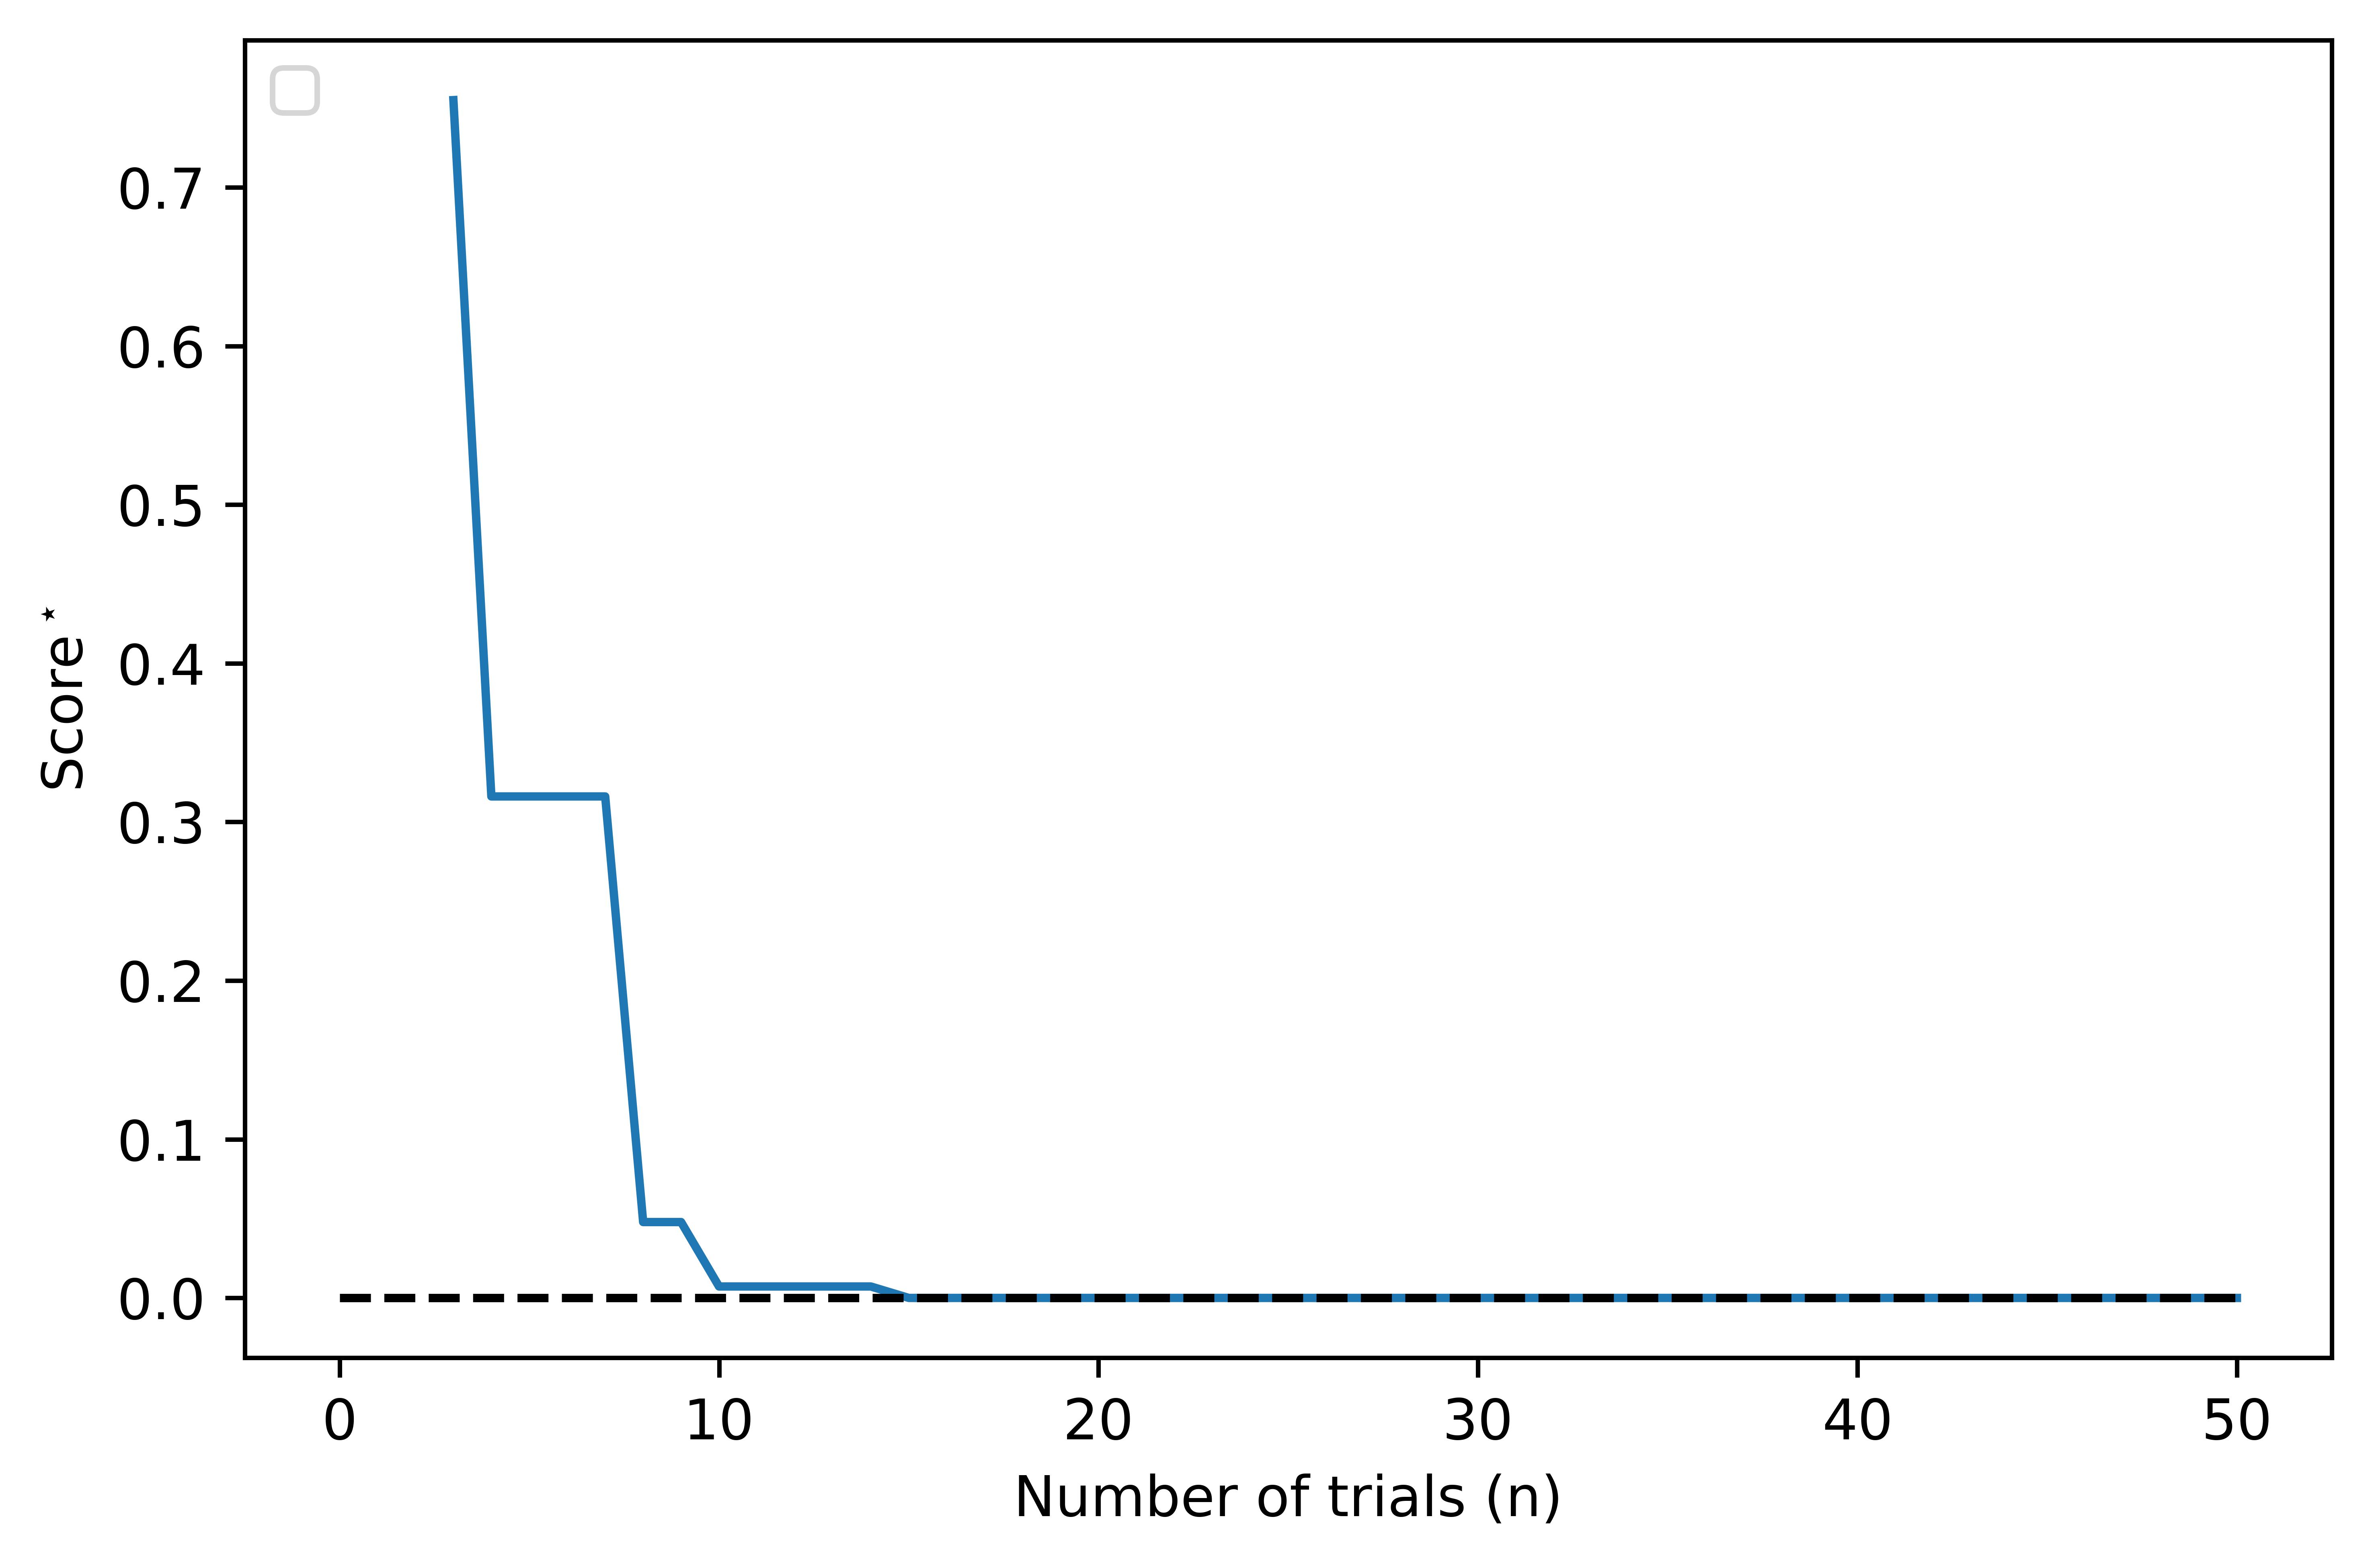

In [12]:
targets = [
    {'target': 20, 'limit': 15, 'priority': 1},
    {'target': 15, 'limit': 12, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

score_1 = run_HOLA_trials(50, targets)
print(score_1)

Minimum score is 0.2889987500000002
No valid combination found for the provided inputs: x1=16.0, x2=100.0, x3=6.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=4.0, x4=22.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=62.5, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=8.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=20.0, x2=87.5, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=20.0, x2=100.0, x3=6.0, x4=22.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=6.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=24.0, x2=100.0, x3=8.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=20.0, x2=62.5, x3=8.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=87.5, x3=4.0, x4=52.0, x5=78.0.
N

run   vds  nfing     wg   gdg   gsg      Pout       PAE         Tj  \
19   19  24.0    6.0   87.5  52.0  78.0  26.50095  15.59353  107.31497   
3     3  24.0    8.0   75.0  22.0  78.0  26.19259  15.10081  109.76405   
10   10  20.0    4.0  100.0  52.0  78.0  24.56290  15.38808   94.09775   
7     7  28.0    6.0   62.5  52.0  78.0  24.77719  15.82283  115.16419   
15   15  28.0    8.0  100.0  52.0  48.0  28.95595  17.17252  124.12722   
39   39  28.0    8.0   62.5  22.0  78.0  25.88174  16.24393  120.23795   
48   48  28.0    4.0   75.0  52.0  48.0  23.66416  16.25104  118.22151   
22   22  16.0    2.0  100.0  52.0  33.0  20.58951  15.38096   81.86071   
20   20  24.0    4.0   62.5  52.0  78.0  21.48020  14.05928  102.32402   
34   34  20.0    4.0   75.0  22.0  33.0  21.31438  13.81974  102.53820   
32   32  28.0    2.0   87.5  22.0  78.0  21.46496  16.07789  121.33586   
27   27  24.0    8.0   50.0  52.0  48.0  22.97453  12.97172  102.54368   
13   13  20.0    6.0   62.5  52.0  48.0  22.16023  13.29634   92.83427   
4     4  24.0    2.0   87.5  22.0  48.0  20.26709  14.53945  113.16404   
8     8  28.0    2.0   75.0  52.0  48.0  20.25087  15.00630  116.25723   
35   35  24.0    6.0   50.0  52.0  48.0  21.64039  12.91665  101.99669   
33   33  16.0    8.0   25.0  52.0  33.0  15.04270   8.74689   68.31912   
36   36  24.0    4.0   37.5  52.0  78.0  18.85532  13.21095   96.19985   
0     0  28.0    4.0   37.5  52.0  78.0  19.73370  13.60280  107.95309   
40   40  28.0    4.0   50.0  22.0  48.0  19.59303  12.96545  119.81288   
38   38  16.0    2.0   37.5  52.0  48.0  12.06104  10.62315   74.09764   
41   41  16.0    6.0   75.0  52.0  78.0   0.00000   0.00000    0.00000   
42   42  20.0    2.0   37.5  22.0  48.0  11.70941   8.70894   87.60645   
43   43  24.0    8.0  100.0  52.0  33.0   0.00000   0.00000    0.00000   
44   44  24.0    2.0   75.0  52.0  33.0  18.96761  13.32839  102.76026   
45   45  20.0    8.0   62.5  22.0  48.0   0.00000   0.00000    0.00000   
46   46  16.0    4.0   87.5  52.0  78.0   0.00000   0.00000    0.00000   
47   47  28.0    6.0   25.0  22.0  48.0  17.12608  10.54641  108.41192   
37   37  20.0    6.0  100.0  22.0  33.0   0.00000   0.00000    0.00000   
31   31  28.0    6.0   87.5  22.0  33.0  25.83602  15.82957  137.65142   
24   24  28.0    4.0  100.0  22.0  33.0  25.03429  15.26002  138.14522   
29   29  20.0    8.0   87.5  22.0  78.0   0.00000   0.00000    0.00000   
1     1  16.0    6.0  100.0  22.0  48.0   0.00000   0.00000    0.00000   
2     2  20.0    2.0   50.0  52.0  33.0  15.35846  11.78852   84.80684   
5     5  20.0    8.0   25.0  52.0  33.0  18.11450  11.93306   78.61855   
6     6  16.0    4.0   75.0  22.0  33.0   0.00000   0.00000    0.00000   
9     9  16.0    8.0   62.5  22.0  78.0   0.00000   0.00000    0.00000   
11   11  24.0    6.0   25.0  22.0  33.0  16.21886  10.07610   94.69084   
12   12  24.0    4.0   37.5  22.0  33.0  14.95765   7.73279  101.62778   
30   30  16.0    4.0   62.5  52.0  48.0  19.67211  13.97278   79.44092   
14   14  16.0    2.0   37.5  22.0  78.0  10.20951   7.92909   74.80454   
17   17  16.0    8.0   75.0  52.0  33.0   0.00000   0.00000    0.00000   
18   18  20.0    4.0   25.0  22.0  48.0  13.53912   9.77582   84.72020   
21   21  20.0    6.0   50.0  22.0  33.0  19.87074  12.11286   96.31251   
23   23  28.0    8.0   37.5  22.0  48.0  20.31424  10.94611  116.81044   
25   25  16.0    6.0   25.0  52.0  48.0  15.48842  10.89297   71.37099   
26   26  20.0    2.0   62.5  22.0  78.0  16.91989  12.58208   92.29661   
28   28  24.0    2.0   25.0  52.0  33.0  14.07453  13.40748   87.47369   
16   16  28.0    2.0   50.0  22.0  78.0  17.64325  14.01013  113.03130   
49   49  16.0    6.0   50.0  22.0  33.0   0.00000   0.00000    0.00000   

       score  
19  0.288999  
3   0.450724  
10  0.582618  
7   0.705353  
15  0.706361  
39  0.776680  
48  0.953056  
22  1.081071  
20  1.300155  
34  1.380768  
32  1.383673  
27  1.385254  
13  1.405886  
4   1.489953  
8   

No handles with labels found to put in legend.


The score for trial 1 is: inf
The score for trial 10 is: 0.45072374999999987
The score for trial 20 is: 0.2889987500000002
The score for trial 30 is: 0.2889987500000002
The score for trial 40 is: 0.2889987500000002
The score for trial 50 is: 0.2889987500000002
[       inf        inf        inf 0.45072375 0.45072375 0.45072375
 0.45072375 0.45072375 0.45072375 0.45072375 0.45072375 0.45072375
 0.45072375 0.45072375 0.45072375 0.45072375 0.45072375 0.45072375
 0.45072375 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875
 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875
 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875
 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875
 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875 0.28899875
 0.28899875 0.28899875]


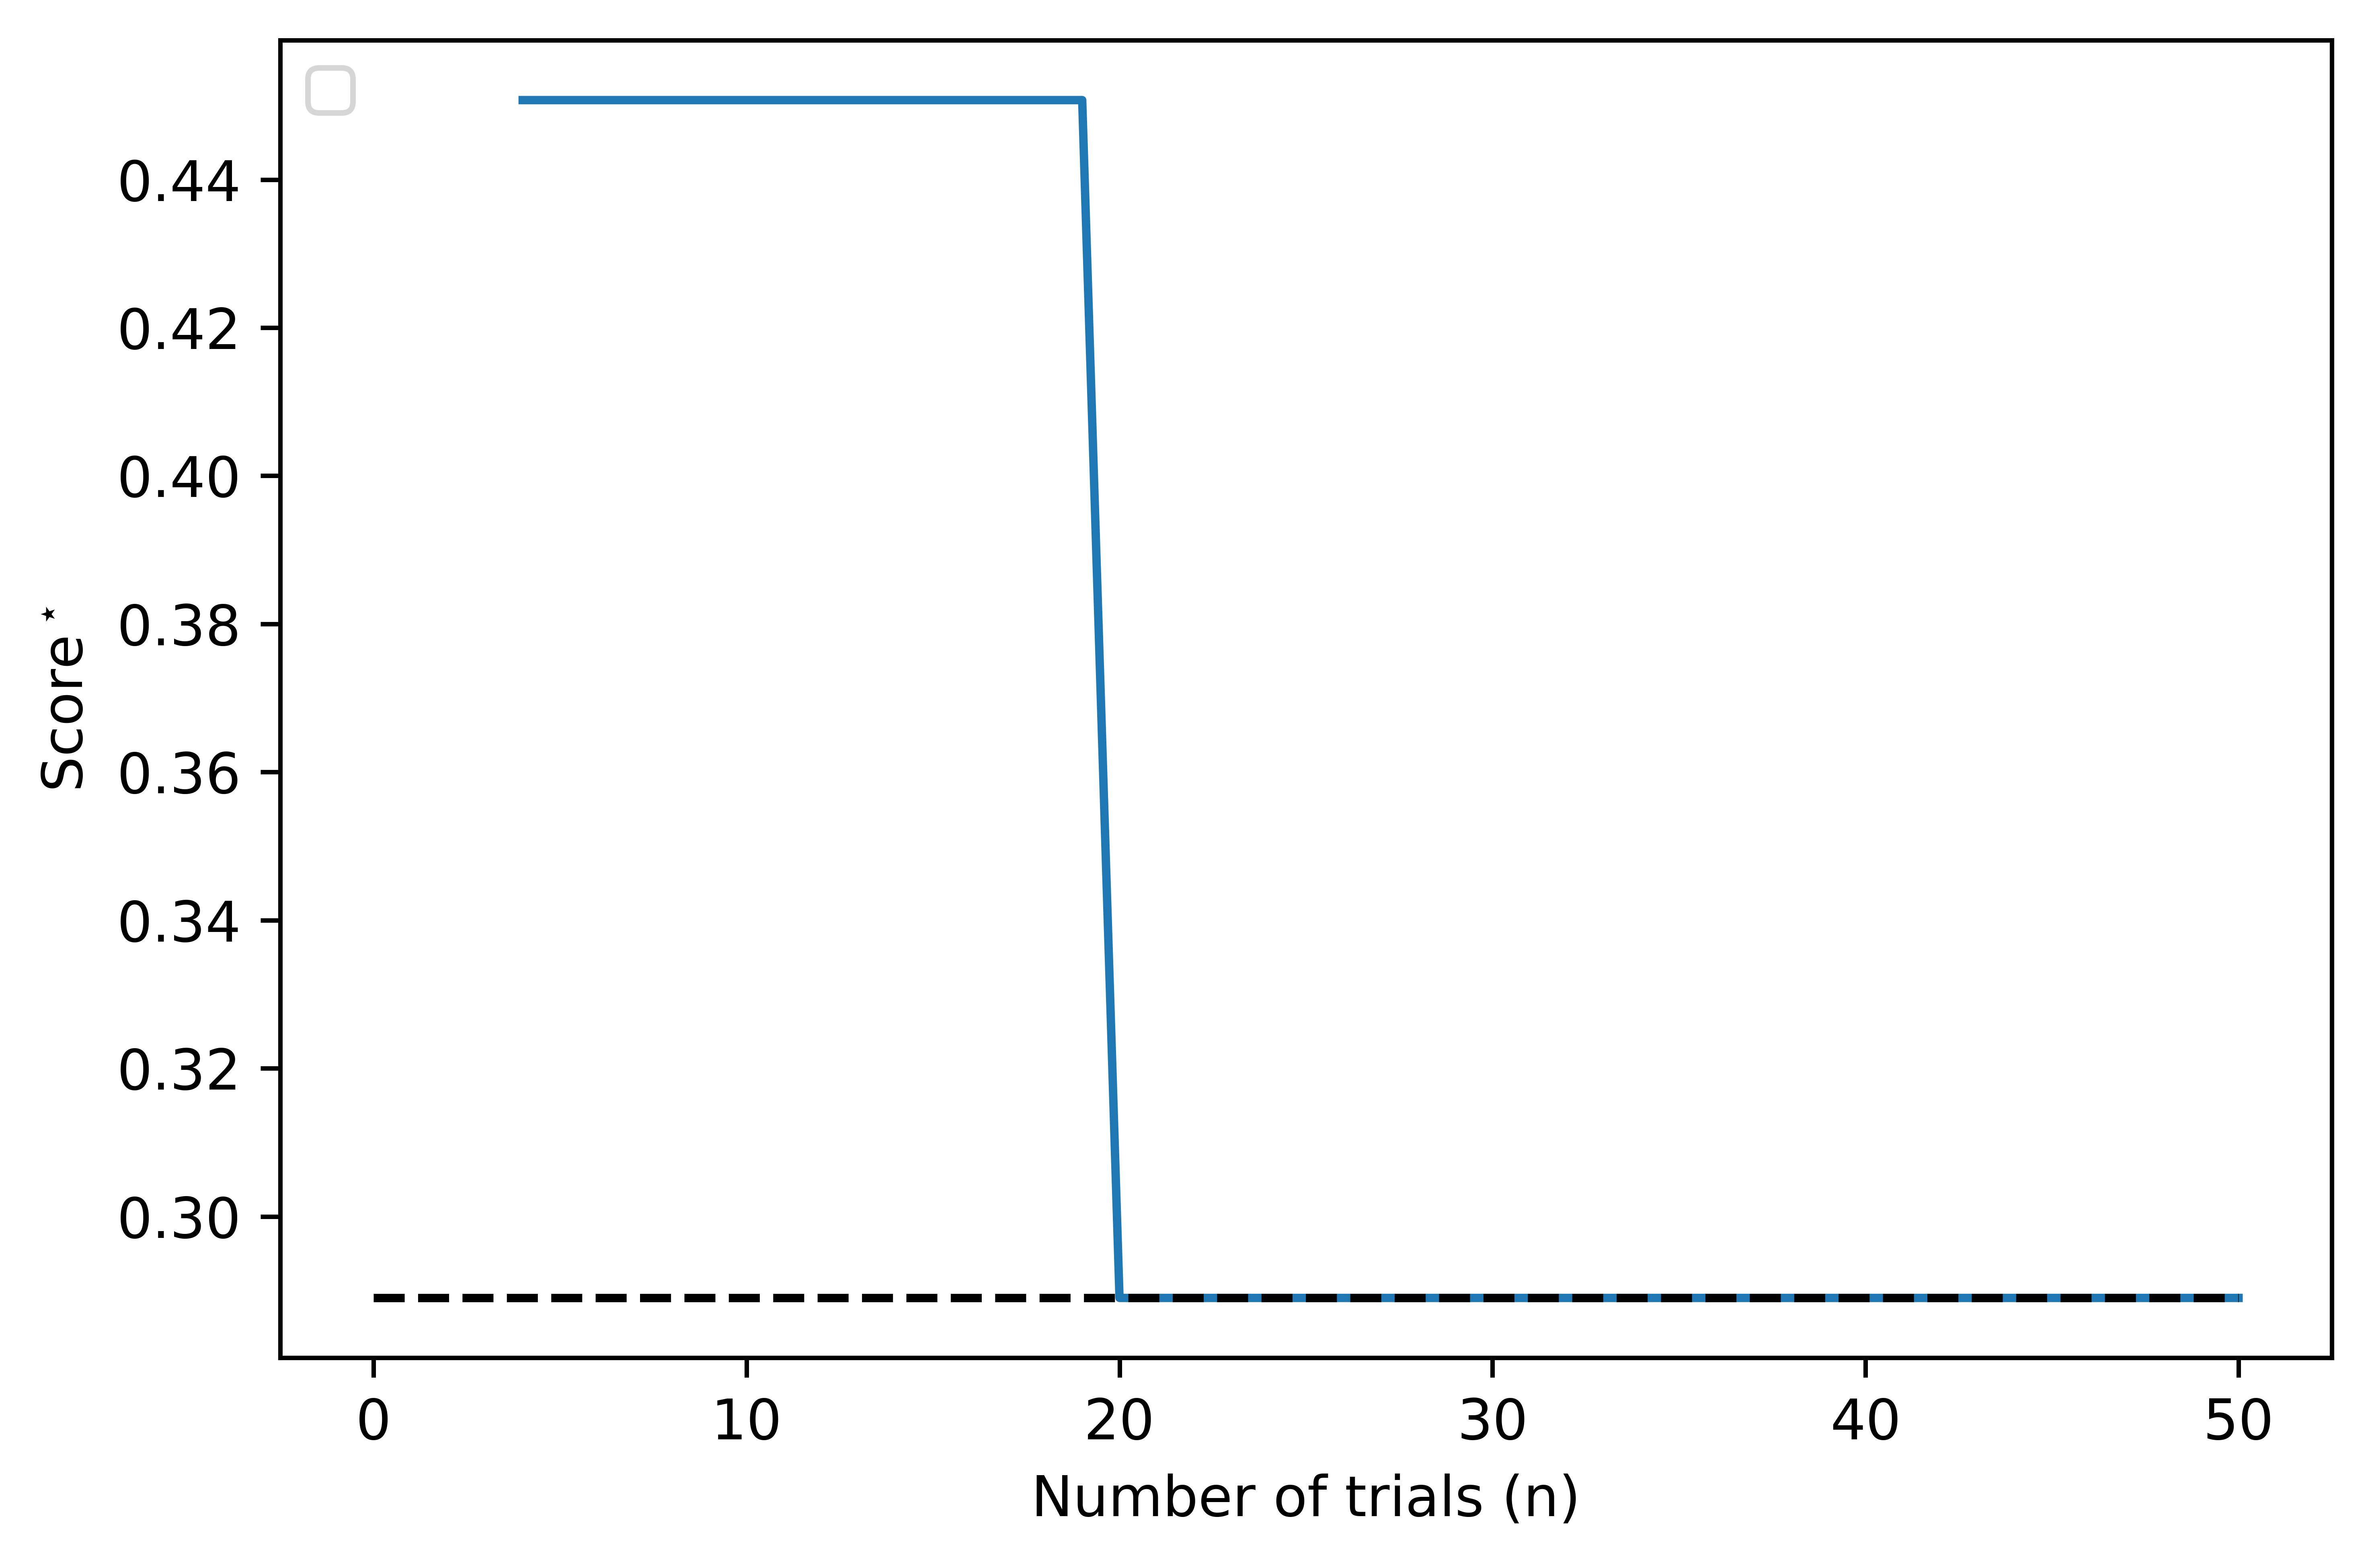

In [20]:
targets_2 = [
    {'target': 28, 'limit': 20, 'priority': 1},
    {'target': 16, 'limit': 12, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

score_2 = run_HOLA_trials(50, targets_2)

print(score_2)

Minimum score is 0.0485005000000001
No valid combination found for the provided inputs: x1=16.0, x2=50.0, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=24.0, x2=87.5, x3=8.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=87.5, x3=6.0, x4=22.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=87.5, x3=4.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=20.0, x2=100.0, x3=8.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=8.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=16.0, x2=62.5, x3=6.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=20.0, x2=62.5, x3=8.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=100.0, x3=4.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=37.5, x3=8.0, x4=52.0, x5=48.0.
No

run   vds  nfing     wg   gdg   gsg      Pout       PAE         Tj  \
5     5  20.0    6.0   75.0  52.0  78.0  24.17474  14.83858   90.97001   
2     2  20.0    4.0  100.0  52.0  48.0  24.25682  15.08842   96.72873   
22   22  16.0    4.0   62.5  52.0  48.0  19.67211  13.97278   79.44092   
30   30  16.0    2.0   87.5  52.0  33.0  19.08692  14.50306   79.97818   
15   15  24.0    6.0   62.5  52.0  78.0  24.06006  15.35608  102.67552   
42   42  20.0    4.0   75.0  22.0  33.0  21.31438  13.81974  102.53820   
29   29  20.0    6.0   50.0  22.0  48.0  20.79732  12.89956   96.40534   
31   31  24.0    8.0   25.0  22.0  78.0  19.17923  12.88798   93.37885   
47   47  24.0    8.0   62.5  22.0  78.0  25.17533  15.21464  108.58406   
13   13  20.0    8.0   25.0  52.0  33.0  18.11450  11.93306   78.61855   
0     0  24.0    2.0   75.0  52.0  33.0  18.96761  13.32839  102.76026   
44   44  28.0    4.0   25.0  52.0  48.0  18.37234  14.51527  104.13855   
18   18  20.0    2.0   62.5  22.0  78.0  16.91989  12.58208   92.29661   
8     8  24.0    4.0   25.0  52.0  78.0  17.02771  12.54696   92.54405   
19   19  28.0    8.0   37.5  52.0  33.0  20.92415  11.37331  105.18719   
24   24  24.0    2.0   50.0  22.0  48.0  16.41526  13.00256  102.62394   
39   39  24.0    6.0   37.5  22.0  33.0  17.97525  10.05594  102.64195   
32   32  24.0    4.0   50.0  22.0  48.0  17.81482  10.23876  108.59103   
1     1  16.0    8.0   50.0  22.0  78.0   0.00000   0.00000    0.00000   
46   46  16.0    2.0   50.0  52.0  48.0  15.47845  13.64542   76.18371   
45   45  20.0    6.0   87.5  22.0  33.0   0.00000   0.00000    0.00000   
3     3  28.0    6.0   37.5  22.0  33.0  18.94913  10.94632  113.61930   
43   43  28.0    6.0   50.0  52.0  78.0  23.60983  16.04091  110.69626   
4     4  28.0    4.0   50.0  22.0  33.0  18.81170  11.61772  119.79433   
41   41  16.0    8.0   37.5  52.0  48.0   0.00000   0.00000    0.00000   
40   40  24.0    2.0  100.0  22.0  78.0  21.90650  15.39607  110.27038   
38   38  16.0    4.0  100.0  52.0  78.0   0.00000   0.00000    0.00000   
37   37  20.0    8.0   62.5  22.0  48.0   0.00000   0.00000    0.00000   
36   36  28.0    2.0   75.0  52.0  33.0  20.02075  14.63719  113.87211   
35   35  28.0    8.0  100.0  52.0  33.0  28.58526  16.73685  125.10072   
34   34  20.0    2.0   25.0  22.0  48.0  10.79511  10.04041   83.16291   
33   33  16.0    6.0   62.5  52.0  78.0   0.00000   0.00000    0.00000   
16   16  24.0    4.0   87.5  22.0  33.0  23.39073  14.62274  120.58155   
6     6  16.0    2.0   25.0  22.0  78.0  11.21197  11.34005   72.11550   
17   17  16.0    6.0   25.0  52.0  48.0  15.48842  10.89297   71.37099   
12   12  28.0    2.0  100.0  22.0  78.0  22.72922  16.87130  122.25427   
11   11  28.0    8.0   62.5  22.0  48.0  24.87997  14.13123  127.82757   
20   20  28.0    2.0   37.5  52.0  48.0  15.21389  11.61763  108.00623   
21   21  20.0    8.0  100.0  22.0  78.0   0.00000   0.00000    0.00000   
10   10  20.0    2.0   50.0  52.0  33.0  15.35846  11.78852   84.80684   
14   14  16.0    4.0   87.5  22.0  48.0   0.00000   0.00000    0.00000   
23   23  24.0    6.0   87.5  22.0  33.0  25.26000  14.82846  123.96521   
25   25  16.0    8.0   75.0  52.0  33.0   0.00000   0.00000    0.00000   
26   26  20.0    4.0   37.5  22.0  48.0  14.89164   9.02422   90.66172   
27   27  28.0    6.0  100.0  52.0  78.0  28.07706  17.43691  118.95838   
28   28  28.0    4.0   75.0  52.0  78.0  24.07327  16.50300  113.76352   
9     9  16.0    6.0   87.5  22.0  33.0   0.00000   0.00000    0.00000   
7     7  24.0    8.0   87.5  52.0  48.0   0.00000   0.00000    0.00000   
48   48  24.0    2.0   37.5  52.0  33.0  12.85118   9.31691   92.17491   
49   49  16.0    8.0  100.0  22.0  48.0   0.00000   0.00000    0.00000   

       score  
5   0.048501  
2   0.336436  
22  0.394787  
30  0.485513  
15  0.633776  
42  0.786245  
29  0.795824  
31  0.917076  
47  0.929203  
13  1.164318  
0   1.311314  
44  1.311538  
18  1.315996  
8   1.319178  
19  

No handles with labels found to put in legend.


The score for trial 1 is: 1.3113138333333336
The score for trial 10 is: 0.0485005000000001
The score for trial 20 is: 0.0485005000000001
The score for trial 30 is: 0.0485005000000001
The score for trial 40 is: 0.0485005000000001
The score for trial 50 is: 0.0485005000000001
[1.31131383 1.31131383 0.3364365  0.3364365  0.3364365  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005  0.0485005  0.0485005  0.0485005  0.0485005
 0.0485005  0.0485005 ]


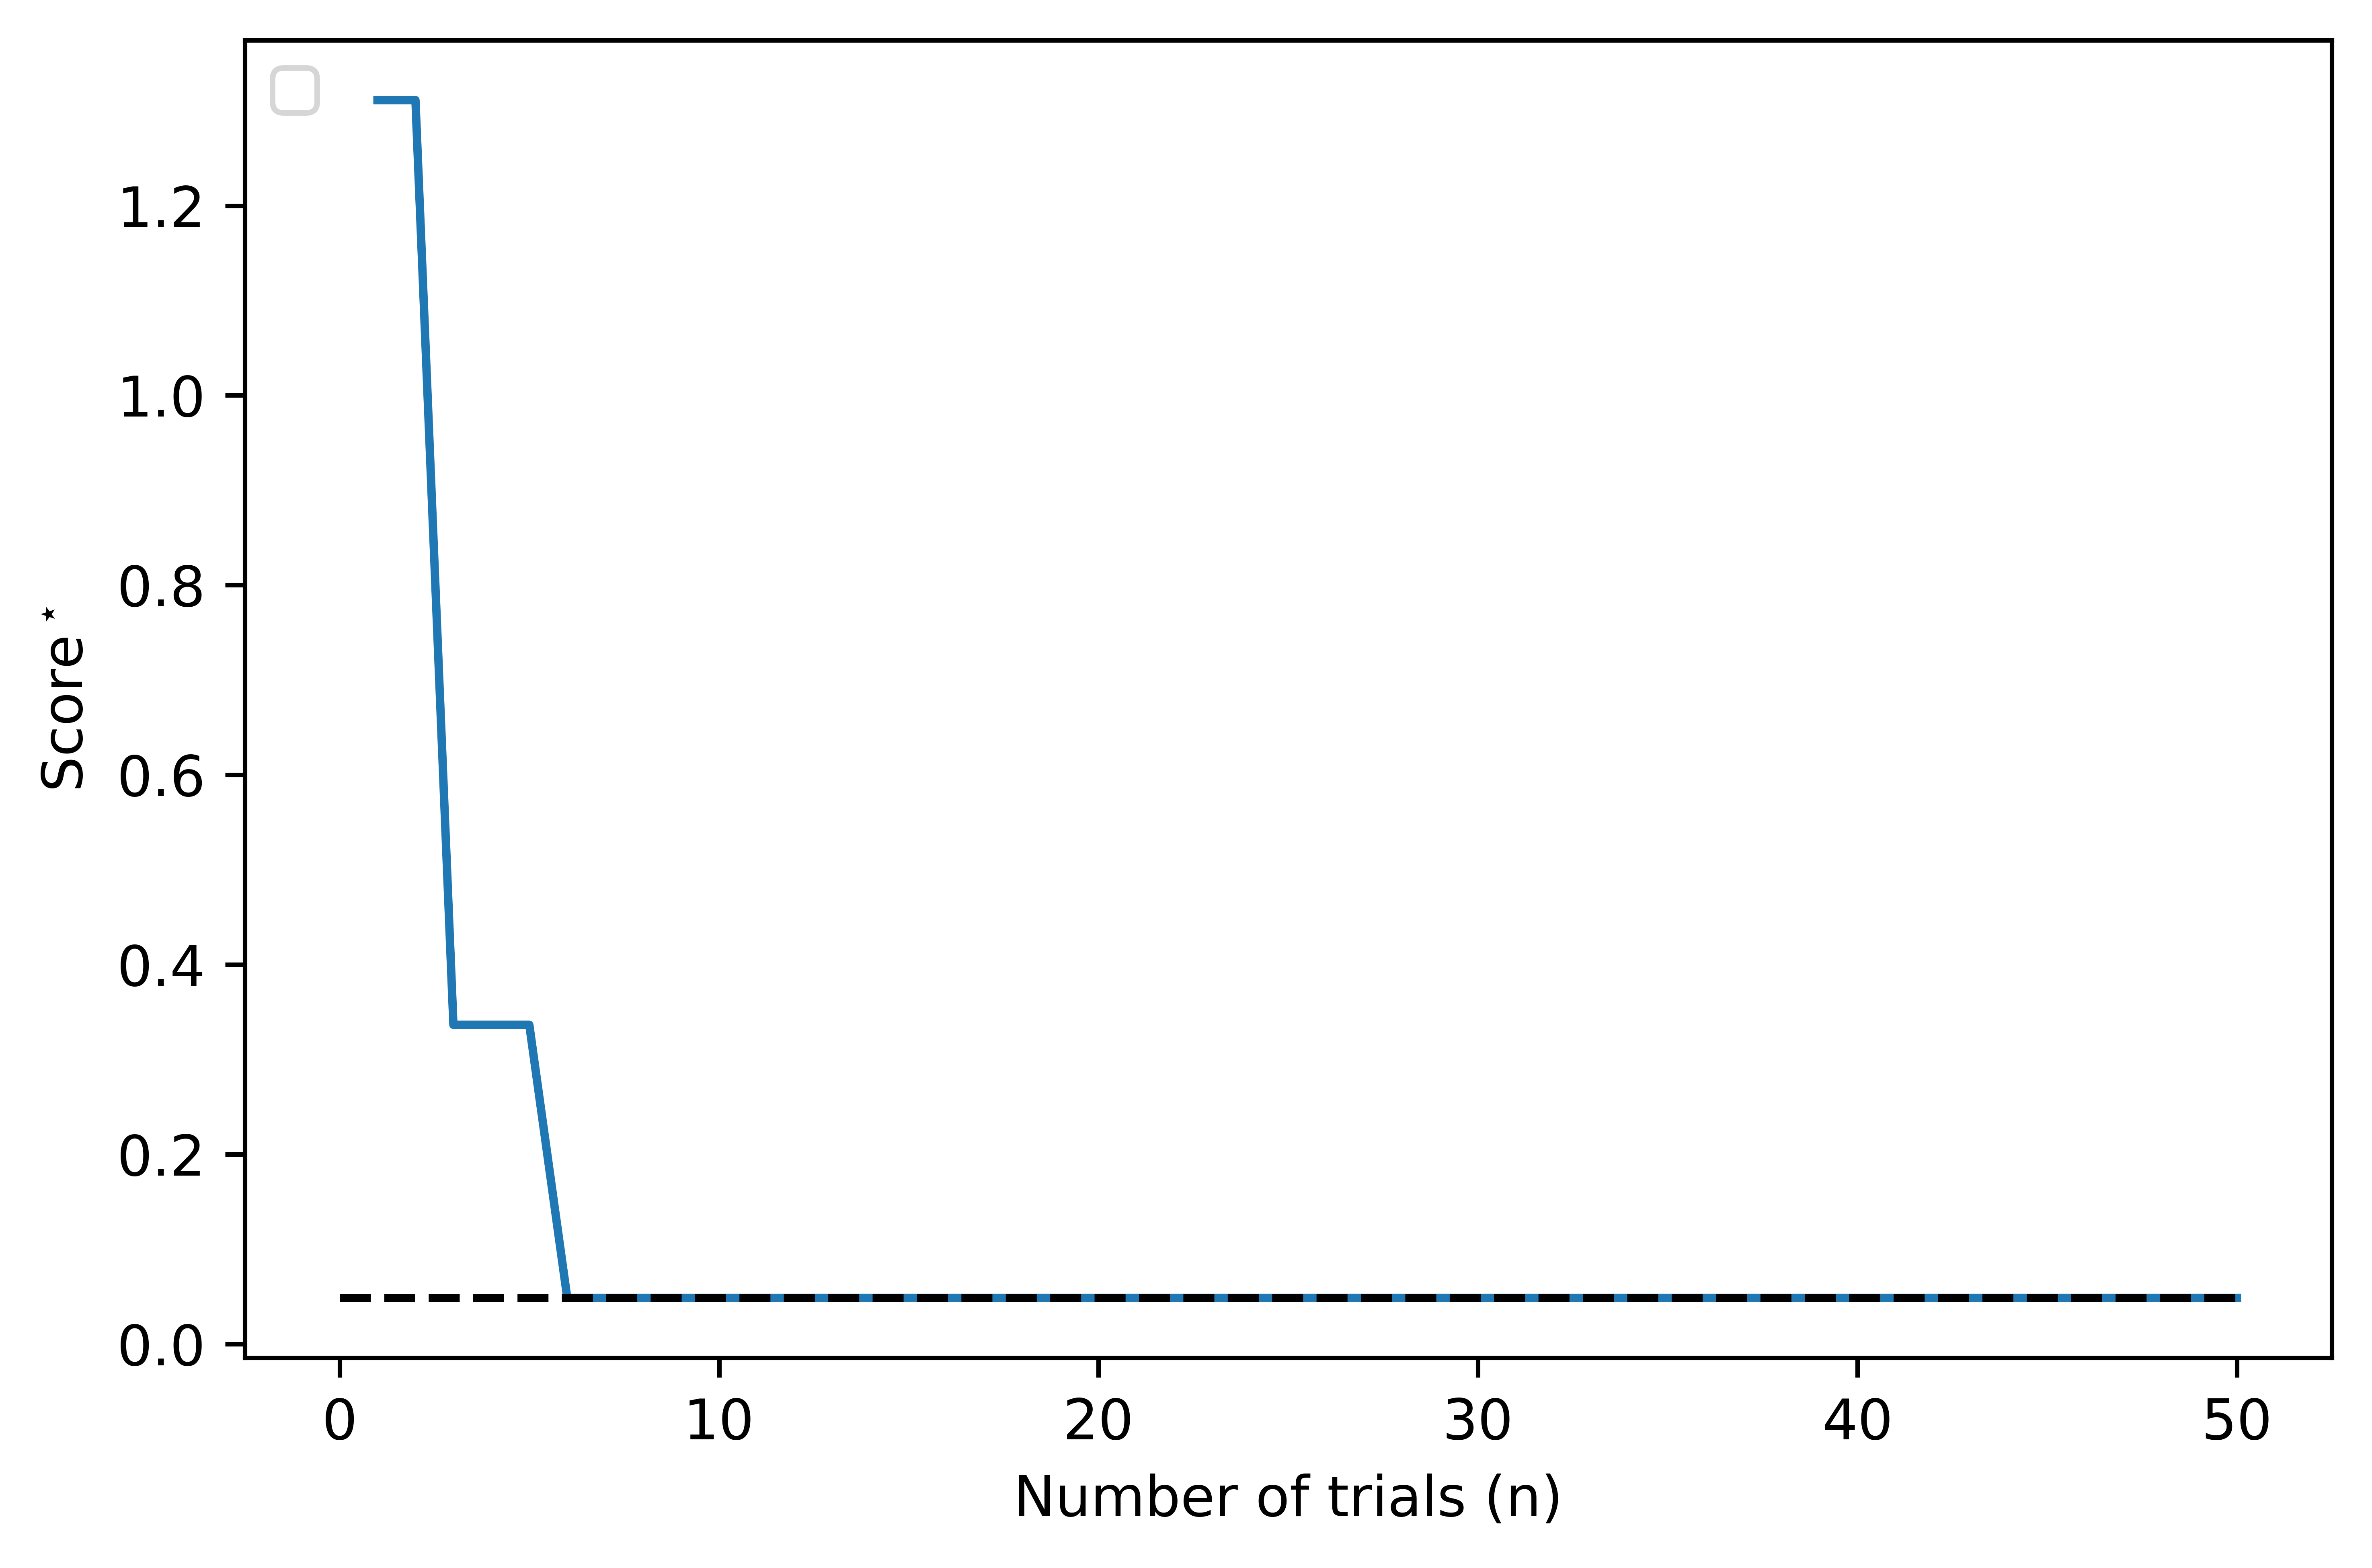

In [14]:
targets_3 = [
    {'target': 22, 'limit': 16, 'priority': 1},
    {'target': 14, 'limit': 10, 'priority': 1},
    {'target': 90, 'limit': 110, 'priority': 1}
]

score_3 = run_HOLA_trials(50, targets_3)

print(score_3)

Minimum score is 0.0
No valid combination found for the provided inputs: x1=16.0, x2=62.5, x3=6.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=20.0, x2=75.0, x3=8.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=100.0, x3=8.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=4.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=37.5, x3=8.0, x4=22.0, x5=48.0.
No valid combination found for the provided inputs: x1=20.0, x2=87.5, x3=6.0, x4=52.0, x5=33.0.
No valid combination found for the provided inputs: x1=24.0, x2=87.5, x3=8.0, x4=52.0, x5=78.0.
No valid combination found for the provided inputs: x1=16.0, x2=75.0, x3=6.0, x4=22.0, x5=78.0.
No valid combination found for the provided inputs: x1=20.0, x2=50.0, x3=8.0, x4=52.0, x5=48.0.
No valid combination found for the provided inputs: x1=16.0, x2=62.5, x3=8.0, x4=22.0, x5=33.0.
No valid combinati

run   vds  nfing     wg   gdg   gsg      Pout       PAE         Tj  \
17   17  24.0    4.0  100.0  52.0  78.0  25.36764  15.84279  106.51206   
6     6  24.0    6.0  100.0  22.0  48.0  26.44724  15.47604  118.62126   
46   46  24.0    6.0   75.0  52.0  33.0  24.14762  14.28900  105.01245   
34   34  28.0    6.0  100.0  22.0  78.0  27.61333  17.20977  124.94234   
3     3  20.0    4.0   87.5  22.0  48.0  23.08156  15.02941  103.63339   
43   43  20.0    4.0   75.0  52.0  78.0  22.65976  15.18112   91.03425   
10   10  28.0    6.0   62.5  52.0  48.0  23.49422  13.28924  117.35916   
18   18  28.0    6.0   50.0  22.0  78.0  22.70120  14.16792  115.38350   
42   42  28.0    8.0   62.5  22.0  33.0  24.14567  12.78057  129.00172   
36   36  20.0    6.0   62.5  52.0  48.0  22.16023  13.29634   92.83427   
41   41  24.0    2.0  100.0  52.0  33.0  21.47553  14.76659  107.28359   
2     2  28.0    8.0   25.0  52.0  78.0  21.62067  13.74657  104.26604   
31   31  16.0    2.0  100.0  22.0  78.0  20.75191  15.80835   83.70850   
13   13  28.0    2.0   87.5  52.0  33.0  21.08480  15.17876  116.61721   
37   37  28.0    2.0   87.5  22.0  78.0  21.46496  16.07789  121.33586   
14   14  24.0    8.0   50.0  22.0  33.0  21.01275  10.82206  111.93743   
38   38  24.0    8.0   25.0  52.0  48.0  20.00234  13.20569   92.72415   
33   33  24.0    4.0   50.0  52.0  48.0  19.77931  12.41607  101.68430   
32   32  16.0    8.0   62.5  22.0  33.0   0.00000   0.00000    0.00000   
35   35  20.0    2.0   37.5  52.0  48.0  13.81843  11.67304   85.31553   
0     0  16.0    6.0   62.5  52.0  33.0   0.00000   0.00000    0.00000   
30   30  24.0    6.0   37.5  52.0  33.0  17.32321   8.58830   95.96026   
40   40  16.0    6.0   25.0  22.0  48.0  14.87247  10.71352   74.70055   
44   44  20.0    8.0  100.0  52.0  78.0   0.00000   0.00000    0.00000   
45   45  28.0    4.0   37.5  22.0  48.0  16.81854   9.86161  114.35387   
47   47  16.0    2.0   37.5  22.0  78.0  10.20951   7.92909   74.80454   
39   39  16.0    4.0   87.5  22.0  33.0   0.00000   0.00000    0.00000   
29   29  28.0    4.0   75.0  22.0  33.0  22.70492  14.05212  130.25408   
24   24  16.0    6.0   75.0  22.0  78.0   0.00000   0.00000    0.00000   
27   27  20.0    4.0   25.0  52.0  78.0  17.09196  14.07789   81.28814   
1     1  24.0    2.0   75.0  22.0  48.0  19.06581  13.71871  110.51024   
4     4  20.0    8.0   75.0  22.0  48.0   0.00000   0.00000    0.00000   
5     5  28.0    4.0   37.5  52.0  78.0  19.73370  13.60280  107.95309   
7     7  16.0    2.0   37.5  52.0  33.0  11.01356   9.12038   70.68622   
8     8  16.0    8.0  100.0  52.0  78.0   0.00000   0.00000    0.00000   
9     9  24.0    4.0   37.5  22.0  33.0  14.95765   7.73279  101.62778   
11   11  20.0    2.0   50.0  22.0  78.0  14.47083  11.19624   90.17644   
12   12  20.0    6.0   25.0  22.0  78.0  17.61110  11.98778   82.91860   
28   28  20.0    8.0   50.0  52.0  48.0   0.00000   0.00000    0.00000   
15   15  16.0    4.0   75.0  52.0  48.0   0.00000   0.00000    0.00000   
19   19  20.0    2.0   62.5  52.0  33.0  16.44583  11.71588   87.88271   
20   20  20.0    6.0   87.5  52.0  33.0   0.00000   0.00000    0.00000   
21   21  28.0    2.0   25.0  22.0  48.0  12.27135  10.28925  103.87859   
22   22  24.0    8.0   87.5  52.0  78.0   0.00000   0.00000    0.00000   
23   23  16.0    4.0   50.0  22.0  33.0  16.76600  11.66143   81.87180   
48   48  16.0    6.0   87.5  52.0  33.0   0.00000   0.00000    0.00000   
25   25  24.0    2.0   62.5  52.0  48.0  17.48370  11.71145  103.05475   
26   26  28.0    8.0   87.5  22.0  33.0  26.89388  15.11645  139.16714   
16   16  16.0    8.0   37.5  22.0  48.0   0.00000   0.00000    0.00000   
49   49  24.0    2.0   25.0  22.0  78.0  12.22079  10.93064   93.98332   

       score  
17  0.000000  
6   0.431063  
46  0.653628  
34  0.747117  
3   1.151064  
43  1.404144  
10  1.613578  
18  1.814871  
42  1.906570  
36  2.044594  
41  2.161364  
2   2.278284  
31  2.548854  
13  2.679981  
37  

No handles with labels found to put in legend.


The score for trial 1 is: inf
The score for trial 10 is: 0.4310630000000003
The score for trial 20 is: 0.0
The score for trial 30 is: 0.0
The score for trial 40 is: 0.0
The score for trial 50 is: 0.0
[     inf      inf 2.278284 1.151064 1.151064 1.151064 0.431063 0.431063
 0.431063 0.431063 0.431063 0.431063 0.431063 0.431063 0.431063 0.431063
 0.431063 0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.      ]


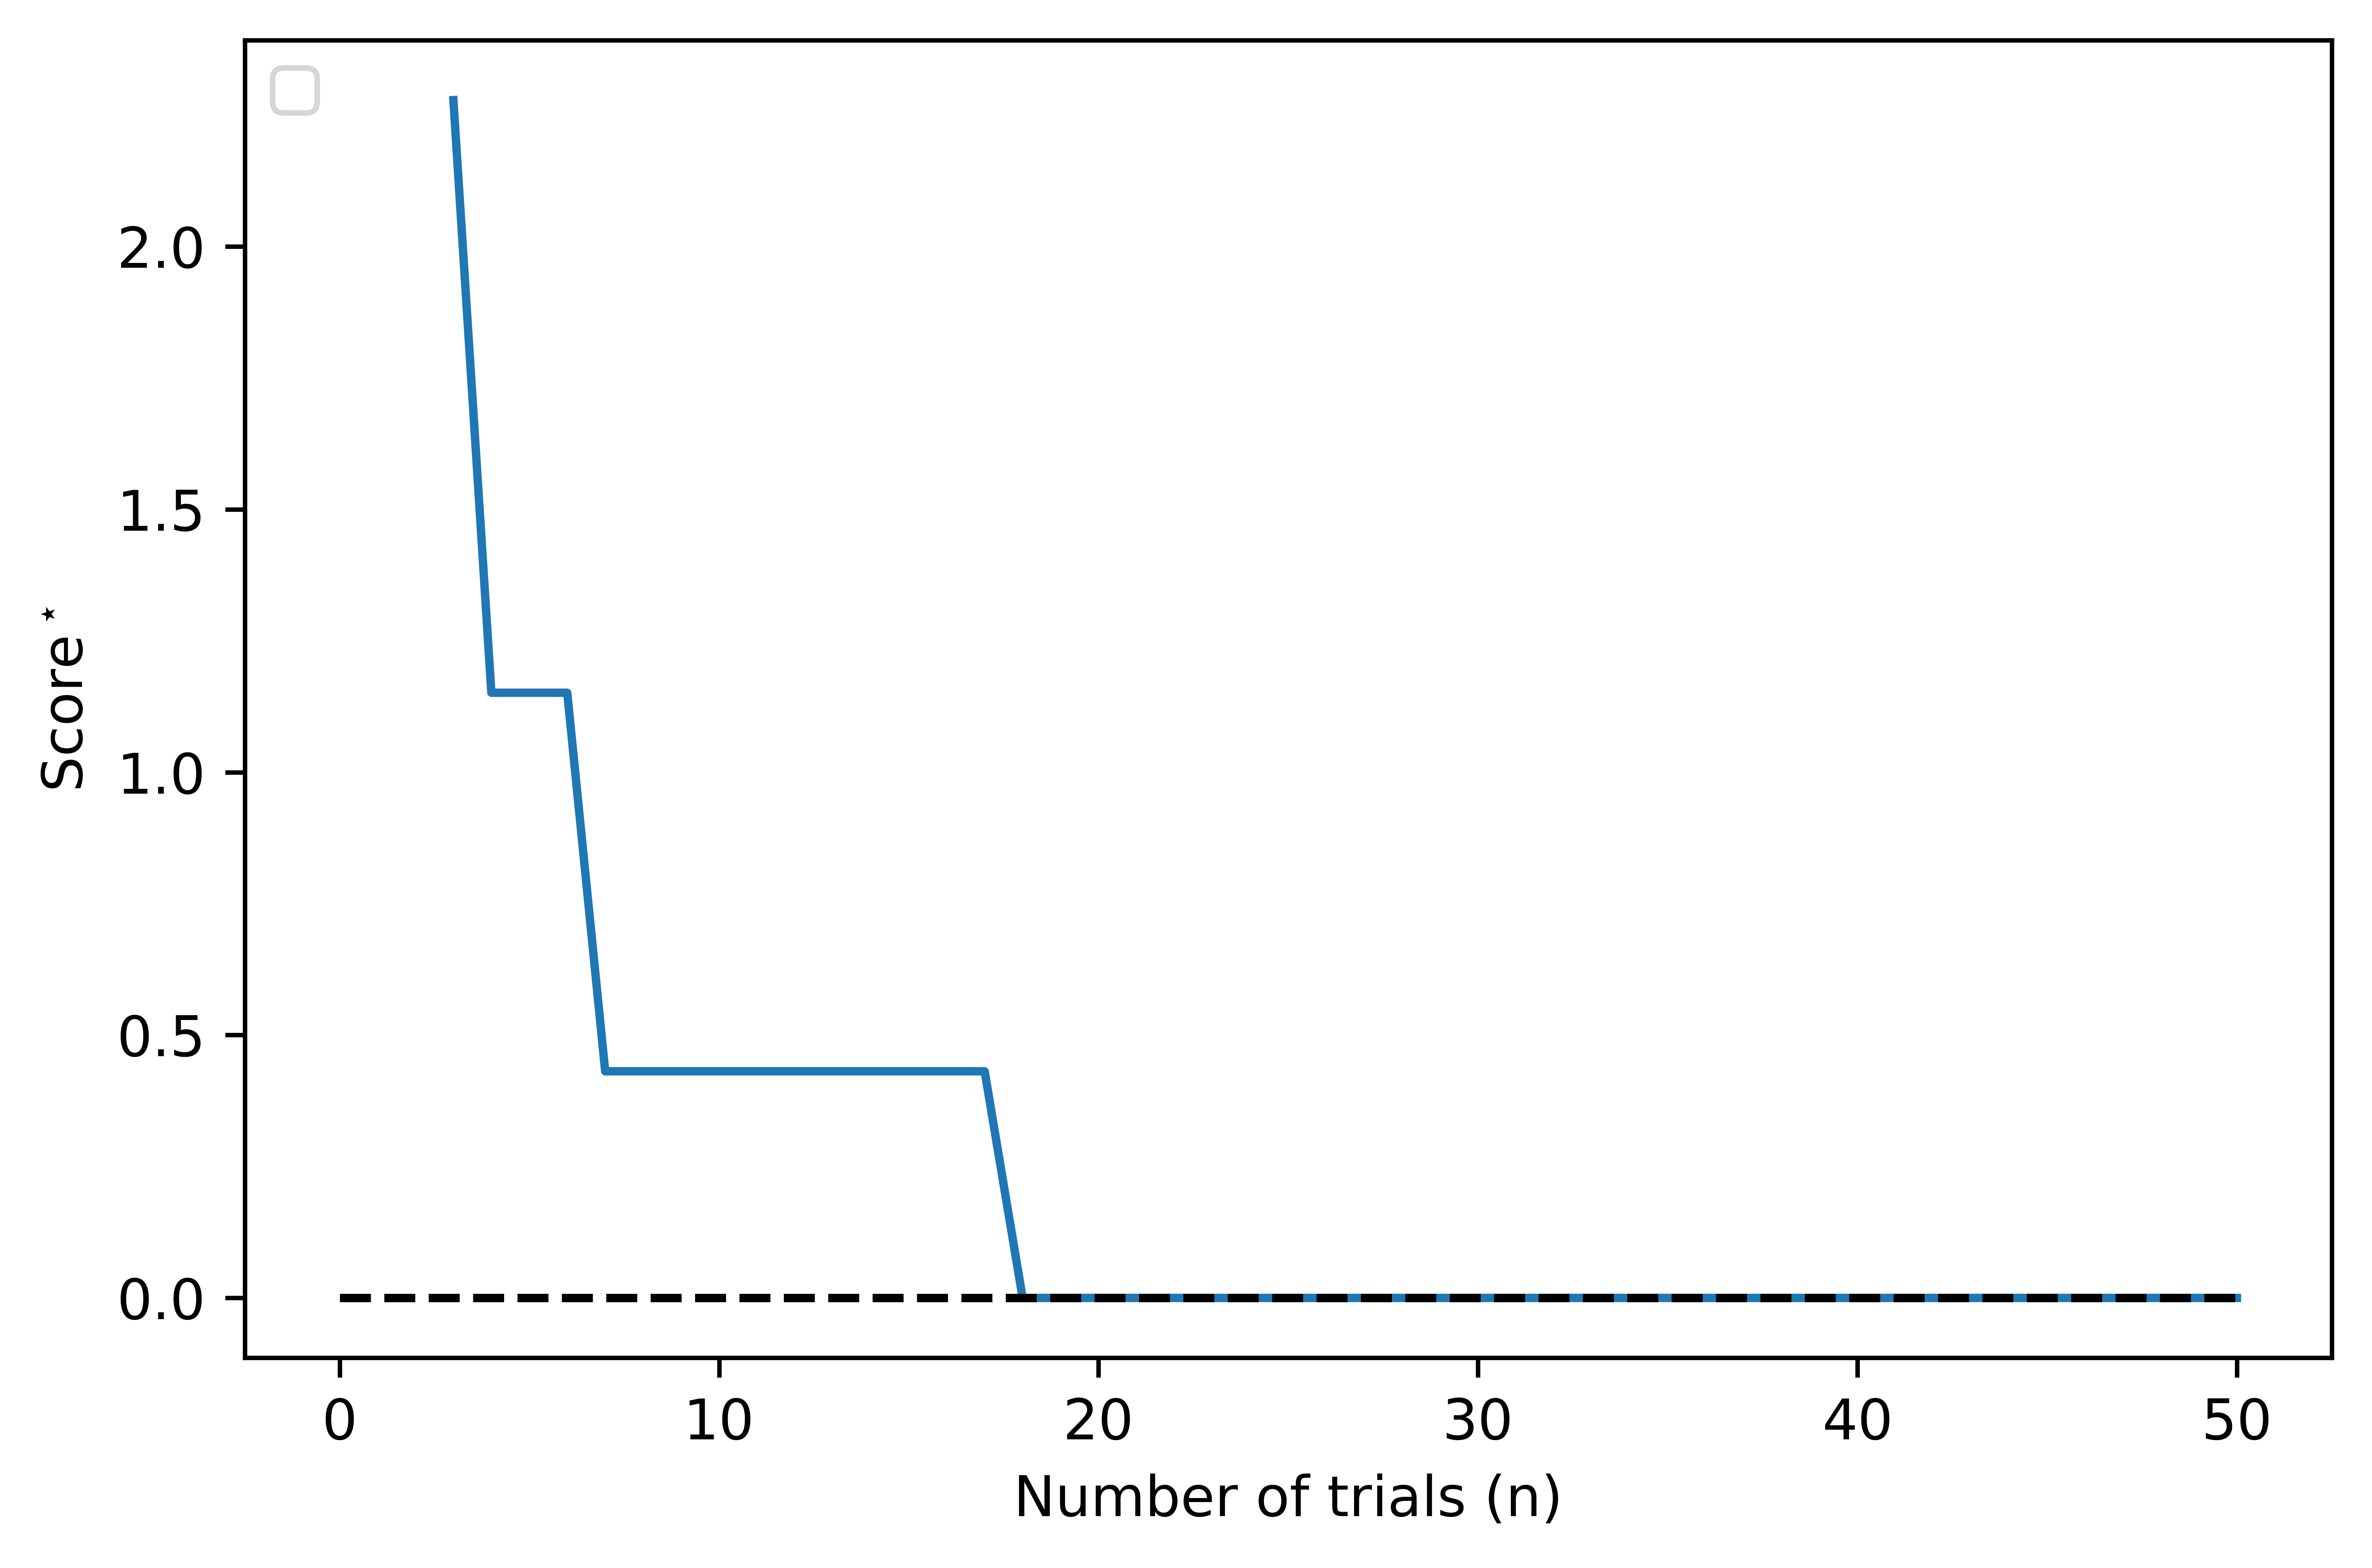

In [21]:
targets_4 = [
    {'target': 25, 'limit': 20, 'priority': 3},
    {'target': 15, 'limit': 10, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

score_4 = run_HOLA_trials(50, targets_4)

print(score_4)

In [22]:
n_trials = range(1, 50 + 1, 1)
xx = [0, n_trials[-1]]  

targets_1 = [
    {'target': 20, 'limit': 15, 'priority': 1},
    {'target': 15, 'limit': 12, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

targets_2 = [
    {'target': 28, 'limit': 20, 'priority': 1},
    {'target': 16, 'limit': 12, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

targets_3 = [
    {'target': 22, 'limit': 16, 'priority': 1},
    {'target': 14, 'limit': 10, 'priority': 1},
    {'target': 90, 'limit': 110, 'priority': 1}
]

targets_4 = [
    {'target': 25, 'limit': 20, 'priority': 3},
    {'target': 15, 'limit': 10, 'priority': 1},
    {'target': 110, 'limit': 130, 'priority': 1}
]

total_score_1 = calc_score(targets_1)
y_val_1 = total_score_1 

total_score_2 = calc_score(targets_2)
y_val_2 = total_score_2

total_score_3 = calc_score(targets_3)
y_val_3 = total_score_3 

total_score_4 = calc_score(targets_4)
y_val_4 = total_score_4 

print(y_val_1)
print(y_val_2)
print(y_val_3)
print(y_val_4)

0.0
0.2889987500000002
0.0485005000000001
0.0


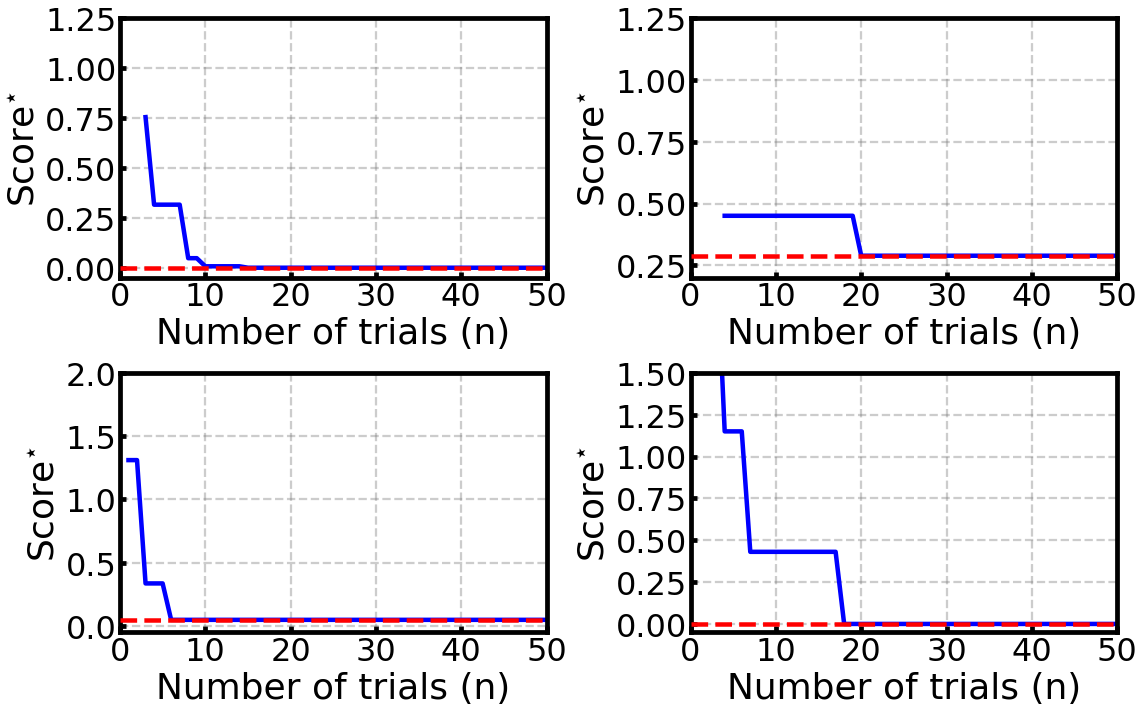

In [23]:
data1_x = n_trials
data1_y = score_1
data2_x = n_trials
data2_y = score_2
data3_x = n_trials
data3_y = score_3
data4_x = n_trials
data4_y = score_4


yy = [y_val_1, y_val_2, y_val_3, y_val_4]

x_labels = [
    r'Number of trials (n)',
    r'Number of trials (n)',
    r'Number of trials (n)',
    r'Number of trials (n)'
]

y_labels = [
    r'Score$^{\star}$',
    r'Score$^{\star}$',
    r'Score$^{\star}$',
    r'Score$^{\star}$'
]

x_ticks = [
    np.arange(0, 51, 10),
    np.arange(0, 51, 10),
    np.arange(0, 51, 10),
    np.arange(0, 51, 10)
]

y_ticks = [
    np.arange(0, 3, 0.25),
    np.arange(0, 3, 0.25),
    np.arange(0, 3, 0.5),
    np.arange(0, 3, 0.25)
]

x_ranges = [
    (0, 50),
    (0, 50),
    (0, 50),
    (0, 50)
]

y_ranges = [
    (-0.05, 1.25),
    (0.25 - 0.05, 1.25),
    (-0.05, 2),
    (-0.05, 1.5)
]

fig, axs = plt.subplots(2, 2, figsize=(16, 10)) 

for i, ax in enumerate(axs.flat):
    ax.plot(eval(f'data{i+1}_x'), eval(f'data{i+1}_y'), color='blue', linewidth=4.5, zorder=2)
    ax.plot(xx, [yy[i]]*2, 'r--', linewidth=4.5, zorder=3)

    ax.set_xticks(x_ticks[i])
    ax.set_yticks(y_ticks[i])
    ax.set_xlim(x_ranges[i])
    ax.set_ylim(y_ranges[i])
    ax.set_xlabel(x_labels[i], fontsize=36, color='black')
    ax.set_ylabel(y_labels[i], fontsize=36, color='black')

    line_width = 4.75
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)

    ax.tick_params(axis='both', which='major', direction='in', length=6, width=4.75, colors='black', labelsize=32)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, colors='black')

    ax.grid(True, which='both', color='grey', linestyle='--', linewidth=2.25, zorder=0, alpha=0.4)

plt.show()
# fig.savefig("Fig_4_v2.pdf", format='pdf', bbox_inches='tight')
